In [1]:
pip install tensorflow-addons==0.11.1

     |████████████████████████████████| 1.1MB 13.1MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
import os
import tensorflow as tf


def regularized_padded_conv(*args, **kwargs):
    return tf.keras.layers.Conv2D(*args, **kwargs, padding='same', kernel_regularizer=_regularizer,
                                  kernel_initializer='he_normal', use_bias=False)


def BN_ReLU(x):
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)


def shortcut(x, filters, stride, mode):
    if x.shape[-1] == filters:
        return x
    elif mode == 'B':
        return regularized_padded_conv(filters, 1, strides=stride)(x)
    elif mode == 'B_original':
        x = regularized_padded_conv(filters, 1, strides=stride)(x)
        return tf.keras.layers.BatchNormalization()(x)
    elif mode == 'A':
        return tf.pad(tf.keras.layers.MaxPool2D(1, stride)(x) if stride>1 else x,
                      paddings=[(0, 0), (0, 0), (0, 0), (0, filters - x.shape[-1])])
    else:
        raise KeyError("Parameter shortcut_type not recognized!")
    

def original_block(x, filters, stride=1, **kwargs):
    c1 = regularized_padded_conv(filters, 3, strides=stride)(x)
    c2 = regularized_padded_conv(filters, 3)(BN_ReLU(c1))
    c2 = tf.keras.layers.BatchNormalization()(c2)
    
    mode = 'B_original' if _shortcut_type == 'B' else _shortcut_type
    x = shortcut(x, filters, stride, mode=mode)
    return tf.keras.layers.ReLU()(x + c2)
    
    
def preactivation_block(x, filters, stride=1, preact_block=False):
    flow = BN_ReLU(x)
    if preact_block:
        x = flow
        
    c1 = regularized_padded_conv(filters, 3, strides=stride)(flow)
    if _dropout:
        c1 = tf.keras.layers.Dropout(_dropout)(c1)
        
    c2 = regularized_padded_conv(filters, 3)(BN_ReLU(c1))
    x = shortcut(x, filters, stride, mode=_shortcut_type)
    return x + c2


def bootleneck_block(x, filters, stride=1, preact_block=False):
    flow = BN_ReLU(x)
    if preact_block:
        x = flow
         
    c1 = regularized_padded_conv(filters//_bootleneck_width, 1)(flow)
    c2 = regularized_padded_conv(filters//_bootleneck_width, 3, strides=stride)(BN_ReLU(c1))
    c3 = regularized_padded_conv(filters, 1)(BN_ReLU(c2))
    x = shortcut(x, filters, stride, mode=_shortcut_type)
    return x + c3


def group_of_blocks(x, block_type, num_blocks, filters, stride, block_idx=0):
    global _preact_shortcuts
    preact_block = True if _preact_shortcuts or block_idx == 0 else False
    
    x = block_type(x, filters, stride, preact_block=preact_block)
    for i in range(num_blocks-1):
        x = block_type(x, filters)
    return x


def Resnet(input_shape, n_classes, l2_reg=1e-4, group_sizes=(2, 2, 2), features=(16, 32, 64), strides=(1, 2, 2),
           shortcut_type='B', block_type='preactivated', first_conv={"filters": 16, "kernel_size": 3, "strides": 1},
           dropout=0, cardinality=1, bootleneck_width=4, preact_shortcuts=True):
    
    global _regularizer, _shortcut_type, _preact_projection, _dropout, _cardinality, _bootleneck_width, _preact_shortcuts
    _bootleneck_width = bootleneck_width # used in ResNeXts and bootleneck blocks
    _regularizer = tf.keras.regularizers.l2(l2_reg)
    _shortcut_type = shortcut_type # used in blocks
    _cardinality = cardinality # used in ResNeXts
    _dropout = dropout # used in Wide ResNets
    _preact_shortcuts = preact_shortcuts
    
    block_types = {'preactivated': preactivation_block,
                   'bootleneck': bootleneck_block,
                   'original': original_block}
    
    selected_block = block_types[block_type]
    inputs = tf.keras.layers.Input(shape=input_shape)
    flow = regularized_padded_conv(**first_conv)(inputs)
    
    if block_type == 'original':
        flow = BN_ReLU(flow)
    
    for block_idx, (group_size, feature, stride) in enumerate(zip(group_sizes, features, strides)):
        flow = group_of_blocks(flow,
                               block_type=selected_block,
                               num_blocks=group_size,
                               block_idx=block_idx,
                               filters=feature,
                               stride=stride)
    
    if block_type != 'original':
        flow = BN_ReLU(flow)
    
    flow = tf.keras.layers.GlobalAveragePooling2D()(flow)
    outputs = tf.keras.layers.Dense(n_classes, kernel_regularizer=_regularizer)(flow)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def load_weights_func(model, model_name):
    try: model.load_weights(os.path.join('saved_models', model_name + '.tf'))
    except tf.errors.NotFoundError: print("No weights found for this model!")
    return model


def cifar_wide_resnet(N, K, block_type='preactivated', shortcut_type='B', dropout=0, l2_reg=2.5e-4):
    assert (N-4) % 6 == 0, "N-4 has to be divisible by 6"
    lpb = (N-4) // 6 # layers per block - since N is total number of convolutional layers in Wide ResNet
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(lpb, lpb, lpb), features=(16*K, 32*K, 64*K),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, dropout=dropout, preact_shortcuts=True)
    return model


def WRN_28_2(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(28, 2, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_28_10')
    return model

In [3]:
import tensorflow_probability as tfp
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageFilter


class CTAugment:

  def __init__(self, n_classes, decay=0.99, threshold=0.85, depth=2, n_bins=17):
    self.decay = decay
    self.threshold = threshold
    self.depth = depth
    self.n_bins = n_bins
    self.n_classes = n_classes
  
    # we need some way of storing functions so that we can randomly sample
    # from them. The format below might not be perfect but it is nice if we 
    # can generate a index i wish with which we can access the ith
    # transformation, its corresponding bins and their weights
    self.xforms = []
    self.bins = [[]]
    self.weights = [[]]

    self.AUG_DICT = {
        "autocontrast": {"f": self.autocontrast, "weight": [np.ones(self.n_bins)*1.0]},
        "blur": {"f": self.blur, "weight": [np.ones(self.n_bins)*1.0]},
        "brightness": {"f": self.brightness, "weight":[np.ones(self.n_bins)*1.0]},
        "color": {"f": self.color, "weight": [np.ones(self.n_bins)*1.0]},
        "contrast": {"f": self.contrast, "weight": [np.ones(self.n_bins)*1.0]},
        "cutout": {"f": self.cutout, "weight": [np.ones(self.n_bins)*1.0]},
        "equalize": {"f": self.equalize, "weight": [np.ones(self.n_bins)*1.0]},
        "invert": {"f": self.invert, "weight": [np.ones(self.n_bins)*1.0]},
        "identity": {"f": self.identity, "weight": [np.ones(self.n_bins)*1.0]},
        "posterize": {"f": self.posterize, "weight": [np.ones(self.n_bins)*1.0]},
        "rescale": {"f": self.rescale, "weight": [np.ones(self.n_bins)*1.0, np.ones(6)*1.0]},
        "rotate": {"f": self.rotate, "weight": [np.ones(self.n_bins)*1.0]},
        "sharpness": {"f": self.sharpness, "weight": [np.ones(self.n_bins)*1.0]},
        "shear_x": {"f": self.shear_x, "weight": [np.ones(self.n_bins)*1.0]},
        "shear_y": {"f": self.shear_y, "weight": [np.ones(self.n_bins)*1.0]},
        "smooth": {"f": self.smooth, "weight": [np.ones(self.n_bins)*1.0]},
        "solarize": {"f": self.solarize, "weight": [np.ones(self.n_bins)*1.0]},
        "translate_x": {"f": self.translate_x, "weight": [np.ones(self.n_bins)*1.0]},
        "translate_y": {"f": self.translate_y, "weight": [np.ones(self.n_bins)*1.0]}
    }
    self.N = len(self.AUG_DICT.keys())
    self.options = list(self.AUG_DICT.keys())

    self.batch_choices = []
    self.batch_bins = []

  def weight_to_p(self, weight):
        p = weight + (1 - self.decay)  # Avoid to have all zero.
        p = p / p.max()
        p[p < self.threshold] = 0
        return p/np.sum(p)

  def augment(self, x):
    aug_x = Image.fromarray(np.uint8(255*x))


    choices = [self.options[i] for i in np.random.choice(np.arange(self.N), self.depth, replace=False)]
    bins = []

    for k in range(self.depth):
        choice_key = choices[k]
        
        transformation = self.AUG_DICT[choice_key]["f"]
        # pick weights for correpsonding function and set weigths to 0 if they 
        # are less than 0.8
        w = self.AUG_DICT[choice_key]["weight"][0]
        p = self.weight_to_p(w)
        curr_bins = {}
        curr_bins["bin"] = np.random.choice(np.arange(self.n_bins), p=p)

        if choice_key=="rescale":
          w = self.AUG_DICT[choice_key]["weight"][1]
          p = self.weight_to_p(w)
          curr_bins["bin2"] = np.random.choice(np.arange(6), p=p)

        # we should probably copy here so we do not overwrite original
        aug_x = transformation(aug_x, **curr_bins)
        bins.append(curr_bins)

    return np.array(aug_x), choices, bins

  def augment_batch(self, batch):
    aug_batch = tf.identity(batch)

    #aug_batch = tf.map_fn(aug_batch, self.augment)
    batch_choices = []
    batch_bins = []
    
    if batch.ndim == 3:
      sample, choices, bins = self.augment(sample)
      batch_choices.append(choices)
      batch_bins.append(bins)
    elif batch.ndim == 4:
      for sample in aug_batch:
        sample, choices, bins = self.augment(sample)
        batch_choices.append(choices)
        batch_bins.append(bins)

    return aug_batch, batch_choices, batch_bins

  def update_weights(self, label, pred, choices, bins):
    omega = 1 - 1 / (2*self.n_classes) * np.sum(tf.math.abs(label - pred))

    for k in range(self.depth):

      w = self.AUG_DICT[choices[k]]["weight"][0]
      #tmp = np.copy(w)
      w[bins[k]["bin"]] = self.decay * w[bins[k]["bin"]] + (1 - self.decay) * omega
      #print(tmp-w)
      if choices[k] == "rescale":
        w = self.AUG_DICT[choices[k]]["weight"][1]
        #tmp = np.copy(w)
        w[bins[k]["bin2"]] = self.decay * w[bins[k]["bin2"]] + (1 - self.decay) * omega
        #print(tmp-w)


  def update_weights_batch(self, labels, preds, choices, bins):
    [self.update_weights(l, p, c, b) for l, p, c, b in zip(labels, preds, choices, bins)]

  def get_param(self, r_min, r_max, bin):
      possible_value = np.linspace(r_min, r_max, self.n_bins)
      return possible_value[bin]

  def autocontrast(self, x, bin):
      param = self.get_param(0, 1, bin)
      return Image.blend(x, ImageOps.autocontrast(x), param)
  
  def blur(self, x, bin):
      param = self.get_param(0, 1, bin)
      return Image.blend(x, x.filter(ImageFilter.BLUR), param)
  
  def brightness(self, x, bin):
      param = self.get_param(0, 1, bin)
      return ImageEnhance.Brightness(x).enhance(0.1 + 1.9*param)

  def color(self, x, bin):
      param = self.get_param(0, 1, bin)
      return ImageEnhance.Color(x).enhance(0.1 + 1.9*param)

  def contrast(self, x, bin):
      param = self.get_param(0, 1, bin)
      return ImageEnhance.Contrast(x).enhance(0.1 + 1.9*param)

  def cutout(self, x, bin):
    """Taken directlly from FixMatch code"""
    level = self.get_param(0, 0.5, bin)

    size = 1 + int(level * min(x.size) * 0.499)
    img_height, img_width = x.size
    height_loc = np.random.randint(low=0, high=img_height)
    width_loc = np.random.randint(low=0, high=img_width)
    upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
    lower_coord = (min(img_height, height_loc + size // 2), min(img_width, width_loc + size // 2))
    pixels = x.load()  # create the pixel map
    for i in range(upper_coord[0], lower_coord[0]):  # for every col:
        for j in range(upper_coord[1], lower_coord[1]):  # For every row
            pixels[i, j] = (127, 127, 127)  # set the color accordingly
    return x

  def equalize(self, x, bin):
      param = self.get_param(0, 1, bin)
      return Image.blend(x, ImageOps.equalize(x), param)

  def invert(self, x, bin):
      param = self.get_param(0, 1, bin)
      return Image.blend(x, ImageOps.invert(x), param)
  
  def identity(self, x, bin):
      return x

  def posterize(self, x, bin):
      param = int(self.get_param(0, 8, bin))
      return ImageOps.posterize(x, param)

  def rescale(self, x, bin, bin2):
      param = self.get_param(0.5, 1, bin)
      methods = (Image.ANTIALIAS, Image.BICUBIC, Image.BILINEAR, Image.BOX, Image.HAMMING, Image.NEAREST)
      method = methods[bin2]
      s = x.size
      scale = param*0.25
      crop = (scale * s[0], scale * s[1], s[0] * (1 - scale), s[1] * (1 - scale))
      return x.crop(crop).resize(x.size, method)

  def rotate(self, x, bin):
      param = self.get_param(-45, 45, bin)
      angle = int(np.round((2 * param - 1) * 45))
      return x.rotate(angle)

  def sharpness(self, x, bin):
      param = self.get_param(0, 1, bin)
      return ImageEnhance.Sharpness(x).enhance(0.1 + 1.9*param)

  def shear_x(self, x, bin):
      param = self.get_param(-0.3, 0.3, bin)
      shear = (2 * param - 1) * 0.3
      return x.transform(x.size, Image.AFFINE, (1, shear, 0, 0, 1, 0))

  def shear_y(self, x, bin):
      param = self.get_param(-0.3, 0.3, bin)
      shear = (2 * param - 1) * 0.3
      return x.transform(x.size, Image.AFFINE, (1, 0, 0, shear, 1, 0))

  def smooth(self, x, bin):
      param = self.get_param(0, 1, bin)
      return Image.blend(x, x.filter(ImageFilter.SMOOTH), param)

  def solarize(self, x, bin):
      param = self.get_param(0, 1, bin)
      th = int(param * 255.999)
      return ImageOps.solarize(x, th)

  def translate_x(self, x, bin):
      param = self.get_param(-0.3, 0.3, bin)
      delta = (2 * param - 1) * 0.3
      return x.transform(x.size, Image.AFFINE, (1, 0, delta, 0, 1, 0))

  def translate_y(self, x, bin):
      param = self.get_param(-0.3, 0.3, bin)
      delta = (2 * param - 1) * 0.3
      return x.transform(x.size, Image.AFFINE, (1, 0, 0, 0, 1, delta))

In [4]:
class OurCosineDecay(tf.keras.experimental.CosineDecay):
  
  def decayed_learning_rate(step):
    old_lr = super(OurCosineDecay, self).decayed_learning_rate(step)

    #new_lr
    step = min(step, decay_steps)
    cosine_decay = cos(7 * pi * step / (16 * decay_steps))
    return initial_learning_rate * cosine_decay

In [5]:
import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
logging.getLogger('tensorflow').disabled = True

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tqdm import tqdm, tqdm_notebook


def training(model, ds_l, ds_u, hparams, mean=None, std=None, lr_values=[0.01, 0.1, 0.01, 0.001], lr_boundaries=[400, 32000, 48000, 64000],
                   val_interval=2000, log_interval=200, batch_size=128):

    #schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=lr_boundaries[:-1], values=lr_values)
    schedule = OurCosineDecay(hparams['eta'], hparams['K'])
    optimizer = tf.keras.optimizers.SGD(schedule, momentum=hparams['beta'], nesterov=hparmas['nesterov'])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    cta = CTAugment(hparams['cta_classes'], hparams['cta_decay'], hparams['cta_threshold'], hparams['cta_depth'])
    
    def train_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        #x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40) #must fix ds independent shape
        #x = tf.image.random_crop(x, (32, 32, 3))          #must fix ds independent shape
        if mean is not None and std is not None:
          x = (x - mean) / std
        return x, y

    def valid_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        if mean is not None and std is not None:
          x = (x - mean) / std
        return x, y


    #ds['train'] = ds['train'].map(train_prep).shuffle(10000).repeat().batch(batch_size).prefetch(-1)
    ds_l['train'] = ds_l['train'].map(train_prep).batch(hparams['B']).prefetch(-1)
    ds_u['train'] = ds_u['train'].map(train_prep).batch(hparams['mu'] * hparams['B']).prefetch(-1)
    
    ds_l['test'] = ds_l['test'].map(valid_prep).batch(batch_size*4).prefetch(-1)

    #runid = run_name + '_x' + str(np.random.randint(10000))
    #writer = tf.summary.create_file_writer(logdir + '/' + runid)
    accuracy = tf.metrics.SparseCategoricalAccuracy()
    cls_loss = tf.metrics.Mean()
    reg_loss = tf.metrics.Mean()
    
    #print(f"RUNID: {runid}")
    #tf.keras.utils.plot_model(model)#, os.path.join('saved_plots', runid + '.png'))

    def weak_transformation(x):
      x = tf.image.random_flip_left_right(x)
      max_shift = tf.cast(x.shape[1]*0.125, dtype=tf.dtypes.int32)
      shift = tf.random.uniform([x.shape[0], 2], minval=-max_shift, maxval=max_shift, dtype=tf.dtypes.int32)
      return tfa.image.translate(x, tf.cast(shift, tf.dtypes.float32))
      

    def pseudolabel(class_dist):
        argmax = tf.math.argmax(class_dist, axis=1)
        return tf.one_hot(argmax, class_dist.shape[1])

    def threshold_gate(one_hot, logits, threshold):
        max_probs = tf.math.multiply(one_hot, tf.nn.softmax(logits))
        return tf.cast(max_probs > threshold, max_probs.dtype)# * max_probs

    
    #@tf.function
    def step(x, y, training):
        with tf.GradientTape() as tape:            
            # unlabeled data
            x_wk = weak_transformation(x)
            outs_wk = model(x_wk, training)  # should this be training or not?
            weak_labels = pseudolabel(outs_wk)
            weak_labels = threshold_gate(weak_labels, outs_wk, hparams['threshold'])

            x_str, choices, bins = cta.augment_batch(x)

            outs_str = model(x_str, training)

            cta.update_weights_batch(weak_labels, outs_str, choices, bins)
            
            
            #unlabeled_loss = loss_fn(weak_labels, outs_str)
            
            # labeled data
            #outs = model(x, training)
            #labeled_loss = loss_fn(y, outs)

            #add losses together
            #loss = labeled_loss + lambda * unlabeled_loss

            r_loss = tf.add_n(model.losses)
            outs = model(x, training)
            c_loss = loss_fn(y, outs)
            loss = c_loss + r_loss

        if training:
            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        accuracy(y, outs)
        cls_loss(c_loss)
        reg_loss(r_loss)
        

    training_step = 0
    best_validation_acc = 0
    epochs = lr_boundaries[-1] // val_interval

    
    for epoch in range(epochs):
        for x, y in tqdm(ds['train'].take(val_interval), desc=f'epoch {epoch+1}/{epochs}',
                         total=val_interval, ncols=100, ascii=True):

            training_step += 1
            step(x, y, training=True)

            if training_step % log_interval == 0:
                #with writer.as_default():
                    c_loss, r_loss, err = cls_loss.result(), reg_loss.result(), 1-accuracy.result()
                    print(f" c_loss: {c_loss:^6.3f} | r_loss: {r_loss:^6.3f} | err: {err:^6.3f}", end='\r')

                    tf.summary.scalar('train/error_rate', err, training_step)
                    tf.summary.scalar('train/classification_loss', c_loss, training_step)
                    tf.summary.scalar('train/regularization_loss', r_loss, training_step)
                    tf.summary.scalar('train/learnig_rate', optimizer._decayed_lr('float32'), training_step)
                    cls_loss.reset_states()
                    reg_loss.reset_states()
                    accuracy.reset_states()

        for x, y in ds['test']:
            step(x, y, training=False)

        #with writer.as_default(): TBULATE THE FOLLOWING WHEN UNCOMMENTING!
        tf.summary.scalar('test/classification_loss', cls_loss.result(), step=training_step)
        tf.summary.scalar('test/error_rate', 1-accuracy.result(), step=training_step)
            
        if accuracy.result() > best_validation_acc:
                best_validation_acc = accuracy.result()
                #model.save_weights(os.path.join('saved_models', runid + '.tf'))
                
        cls_loss.reset_states()
        accuracy.reset_states()
            
    
    
def cifar_error_test(model, tr_len=20, vd_len=2):

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.SGD(0.01)

    ds = tfds.load('cifar10', as_supervised=True, in_memory=True)
    std = tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3))
    mean= tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3))
    
    def train_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        x = tf.image.random_flip_left_right(x)
        x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40)
        x = tf.image.random_crop(x, (32, 32, 3))
        x = (x - mean) / std
        return x, y

    def valid_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        x = (x - mean) / std
        return x, y

    ds['train'] = ds['train'].map(train_prep).batch(5).take(tr_len).prefetch(-1)
    ds['test'] = ds['test'].map(valid_prep).batch(5).take(vd_len).prefetch(-1)

    accuracy = tf.metrics.SparseCategoricalAccuracy()
    cls_loss = tf.metrics.Mean()
    reg_loss = tf.metrics.Mean()

    #@tf.function
    def step(x, y, training):
        with tf.GradientTape() as tape:
            r_loss = tf.add_n(model.losses)
            outs = model(x, training)
            c_loss = loss_fn(y, outs)
            loss = c_loss + r_loss

        if training:
            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        accuracy(y, outs)
        cls_loss(c_loss)
        reg_loss(r_loss)
        
    training_step = 0
    for x, y in tqdm(ds['train'], desc=f'test', total=tr_len, ncols=100, ascii=True):

        training_step += 1
        step(x, y, training=True)
        c_loss, r_loss, err = cls_loss.result(), reg_loss.result(), 1-accuracy.result()
        print(f" c_loss: {c_loss:^6.3f} | r_loss: {r_loss:^6.3f} | err: {err:^6.3f}", end='\r')

    for x, y in ds['test']:
        step(x, y, training=False)

In [32]:
import json

#ds = tfds.load('cifar10', as_supervised=True)

#tfds.load('cifar10.3@10-label')
ds = tf.data.TFRecordDataset('cifar10.3@10-label.tfrecord')

with open('cifar10.3@10-label.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

AttributeError: ignored

In [ ]:
model = WRN_28_2()

In [ ]:
# hyperparams
lamda = 1     # proportion of unlabeled loss in total loss
eta = 0.03    # learning rate
beta = 0.09   # momentum
tau = 0.95    # threshold in pseudo-labeling
mu = 0.7      # proportion of unlabeled samples in batch
B = 64        # number of labeled examples in batch(in training)
K = 2 ** 20
nesterov = False
# weight decay
# SGD instead of Adam


#CTAugment params
cta_classes = 10
cta_decay = 0.99
cta_depth = 2
cta_threshold = 0.8

hparams = {'lamda': lamda, 'eta': eta, 'beta': beta, 'tau': tau, 'mu': mu, 'B': B, 'K': K, 'nesterov': False, 
           'cta_classes': cta_classes, 'cta_decay': cta_decay, 'cta_depth': cta_depth, 'cta_threshold': cta_threshold}

training(model, ds_l, ds_u, hparams)

NameError: ignored

In [ ]:
#ds = tfds.load('cifar10', as_supervised=True, in_memory=True)

mean = {
'cifar10': tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3)),
'cifar100': tf.reshape((0.5071, 0.4867, 0.4408), shape=(1, 1, 3)),
}

std = {
'cifar10': tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3)),
'cifar100': tf.reshape((0.2675, 0.2565, 0.2761), shape=(1, 1, 3))
}

In [57]:
from matplotlib import pyplot as plt

#ds = tfds.load('cifar10', split="train")

#cta = CTAugment(10)
#cta.augment_batch(ds.take(4))

for raw_record in ds.take(5):
  parsed = tf.train.Example.FromString(raw_record.numpy())
  #print(parsed)
  parsed.features.feature['image']
  #image, label = example["image"], example["label"]
  print(parsed.features.feature['image'])
  #print(parsed.features.feature['label'])

#print(np.max(image))

#plt.imshow(image)


#train_set = {'images': np.frombuffer(train_X.read(), dtype=np.uint8),
#                     'labels': np.frombuffer(train_y.read(), dtype=np.uint8) - 1}


# Create a description of the features.
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.uint8, default_value=0),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

#parsed_dataset = ds.map(_parse_function)
#parsed_dataset

bytes_list {
  value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\000 \000\000\000 \010\002\000\000\000\374\030\355\243\000\000\010\301IDATH\211-\326\307\216e\327u\200\341\275\366\332\341\244\233\352\336\212\335\325E\213M\221`K\362\310\200\000\333\320\213{l\300\360\300\320@\006\3146\331\241\272\342\215\'\237\235\326\362@\376_\342\373\241(\177\006\020\000 \004$\301\200\022\244\2101H\2314\306\017\037n\377\374/\177|z|\256\017\361\227\377ylNcQ\024]\327\n\001B\306\2337k\224\331\375\227\027\301\306{\'d0\332l\316\027W7\325bm\217\315is~\256\000\004\242\004\220\314$\204T\032\021\331\tb\026 d\333N\377\373\313\3754M\323\000\336\005\"\352\272>\204\010B\256/\262\253\353\352\365)!\346\332\370\365\225Q8S\250n\357.?\374\361\266\230\341\257\237\036__w\312Z\303LRJ)\025H\224\230XL\t\003\223\222\200\343\220\276~\336\366]\217\2309\027\020QJ)\004\307\220\226\253\205\220i\273\333Ji\277\373\335\305\367?n\036\356\267\257/{@\307\340\2111FO\211p\266\270I)R\212\002\004\010\231\342`\263\364\341\347\037S\344q\362D

In [ ]:
cta = CTAugment(10)
#new, choices, bins = cta.augment(image)
tf.print(image.shape)
new = cta.augment_batch(image)
tf.print(new.shape)
plt.imshow(new)

lab = tf.one_hot(1, 10)
pred = tf.random.uniform([10], maxval=1)

#cta.update_weights(lab, pred, choices, bins)

NameError: ignored

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1.0


TypeError: ignored

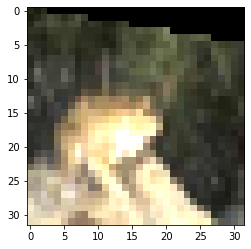

In [ ]:
cta = CTAugment(10)
new, choices, bins = cta.augment(image)
plt.imshow(new)

lab = tf.one_hot(1, 10)
pred = tf.random.uniform([10], maxval=1)

cta.update_weights(lab, pred, choices, bins)